In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [6]:
def ar_process(rng, length, weights=[0.9], noise_std=1.0):
    # 1D AR process
    p = len(weights)
    weights = jnp.array(weights)
    white_noise = jax.random.normal(rng, (length,)) * noise_std
    def step(prev, noise):
        curr = jnp.tensordot(weights, prev, 1) + noise
        prev = jnp.concatenate([prev[1:], curr[None]])
        return prev, curr
    _, x = jax.lax.scan(step, jnp.zeros((p,)), white_noise)
    return x

In [14]:
T = 128
num_samples = 8  # number of samples to draw from the generated sequence
rng = jax.random.PRNGKey(0)

# make some autoregressive noise; normalize to be unit variance
yy = ar_process(rng, T, [0.05, 0.9]) / jnp.sqrt(T)
tt = jnp.linspace(0, 1, len(yy))
f1, f2 = 1, 2
yy = yy + jnp.sin(tt * 2 * jnp.pi * f1) * jnp.sin(f2 * tt * 2 * jnp.pi)

# discretize the continuous signal; optionally we can set num_samples=T to get the full signal
y = yy[T//num_samples//2::T//8]
t = tt[T//num_samples//2::T//8]

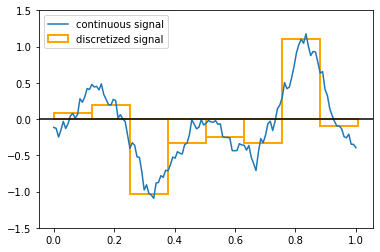

In [27]:
# plot the discretization of the signal
fig, ax = plt.subplots()
ax.plot(tt, yy, label="continuous signal")
ax.bar(t, y, width=1/len(t), facecolor="None", edgecolor="orange", bottom=0, label="discretized signal", linewidth=2.0)
ax.axhline(0, color="black")
ax.set(ylim=(-1.5, 1.5))
ax.legend()

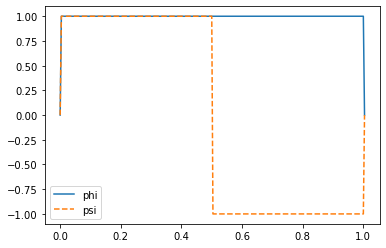

In [20]:
# Let's use Haar wavelets, this is what they look like
import pywt
wavelet = pywt.Wavelet("haar")
phi, psi, x = wavelet.wavefun()  # default is 8
fig, ax = plt.subplots()
ax.plot(x, phi, label="phi")
ax.plot(x, psi, label="psi", ls='--')
ax.legend()

This image from MATLAB's wavedec shows the structure of the DWT:

![](https://www.mathworks.com/help/wavelet/ref/ref_0233x.gif)

X is the original signal

In [22]:
y = np.array(y) # convert to numpy array, since jnp array is read only
# Let's do some MRA:
# First we deconstruct the signal into its DWT coefficients; here we try doing this for different levels of decomposition
coefficients_level1 = pywt.wavedec(y, wavelet, level=1)
coefficients_level2 = pywt.wavedec(y, wavelet, level=2)
coefficients_level3 = pywt.wavedec(y, wavelet, level=3)

# pywt.wavedec() returns a list of coefficients. Below we assign these list of coefficients to variables explicitely.
# The first element of the list is the approximation coefficients, the rest are the detail coefficients.
# Note that PyWavelet uses level 0 to denote V_J, the finest scale, and level 1 to denote V_{J-1}, the next finest scale, etc.
[cA1_l1, cD1_l1] = coefficients_level1
[cA2_l2, cD2_l2, cD1_l2] = coefficients_level2
[cA3_l3, cD3_l3, cD2_l3, cD1_l3] = coefficients_level3

# Since the the list of coefficients have been assigned explicitely to variables, we can set a few of them to zero.
# Doing so will allow us to reconstruct the components in the sum of the signal decomposition.
approx_coeff_level1_only = [cA1_l1, None]
detail_coeff_level1_only = [None, cD1_l1]

approx_coeff_level2_only = [cA2_l2, None, None]
detail_coeff_level2_only = [None, cD2_l2, None]

approx_coeff_level3_only = [cA3_l3, None, None, None]
detail_coeff_level3_only = [None, cD3_l3, None, None]


# By reconstrucing the signal back from only one set of coefficients, we can see how 
# the frequency-sub band for that specific set of coefficient looks like
rec_signal_cA_level1 = pywt.waverec(approx_coeff_level1_only, wavelet)
rec_signal_cD_level1 = pywt.waverec(detail_coeff_level1_only, wavelet)

rec_signal_cA_level2 = pywt.waverec(approx_coeff_level2_only, wavelet)
rec_signal_cD_level2 = pywt.waverec(detail_coeff_level2_only, wavelet)

rec_signal_cA_level3 = pywt.waverec(approx_coeff_level3_only, wavelet)
rec_signal_cD_level3 = pywt.waverec(detail_coeff_level3_only, wavelet)

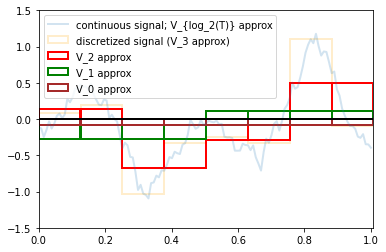

In [32]:
# recall that y is in V_J = V_3
y1 = pywt.waverec([cA1_l1, None], wavelet)  # in V_{J-1} = V_2
y2 = pywt.waverec([cA2_l2, None, None], wavelet) # in V_{J-2} = V_1
y3 = pywt.waverec([cA3_l3, None, None, None], wavelet) # in V_{J-3} = V_0

fig, ax = plt.subplots()
ax.plot(tt, yy, linewidth=2., label="continuous signal; V_{log_2(T)} approx", alpha=0.2)
ax.bar(t, y, width=1/len(t), facecolor="None", edgecolor="orange", bottom=0, linewidth=2., label="discretized signal (V_3 approx)", alpha=0.2)
ax.axhline(0, color="k", linewidth=2.)
ax.bar(t, y1, width=1/len(t), facecolor="None", edgecolor="red", bottom=0, linewidth=2., label="V_2 approx")
ax.bar(t, y2, width=1/len(t), facecolor="None", edgecolor="green", bottom=0, linewidth=2., label="V_1 approx")
ax.bar(t, y3, width=1/len(t), facecolor="None", edgecolor="brown", bottom=0, linewidth=2., label="V_0 approx")
ax.set(ylim=(-1.5, 1.5))
ax.margins(x=0)
ax.legend()

we can also look at the decomposition of the signal into a sum of functions, according to $V_3 = V_0 \oplus W_1 \oplus W_2$

In [33]:
all_coefs = np.concatenate([cA3_l3, cD3_l3, cD2_l3, cD1_l3])
# compute basis coefficients of each component in the sum by zeroing out the coefficients of the other components
basis_coefs = all_coefs * np.eye(len(all_coefs))
basis_coefs

array([[-0.23572257, -0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.        ],
       [-0.        , -0.5365417 ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.81507993, -0.        , -0.        ,
        -0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.7930612 , -0.        ,
        -0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        , -0.08103579,
        -0.        ,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.49242598,  0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.05115169,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        ,  0.84761381]])

In [34]:
y_comps = []
for i in range(len(basis_coefs)):
    coefs = basis_coefs[i]
    coefs = [coefs[:1], coefs[1:2], coefs[2:4], coefs[4:]]
    y_comp = pywt.waverec(coefs, wavelet)
    y_comps.append(y_comp) 

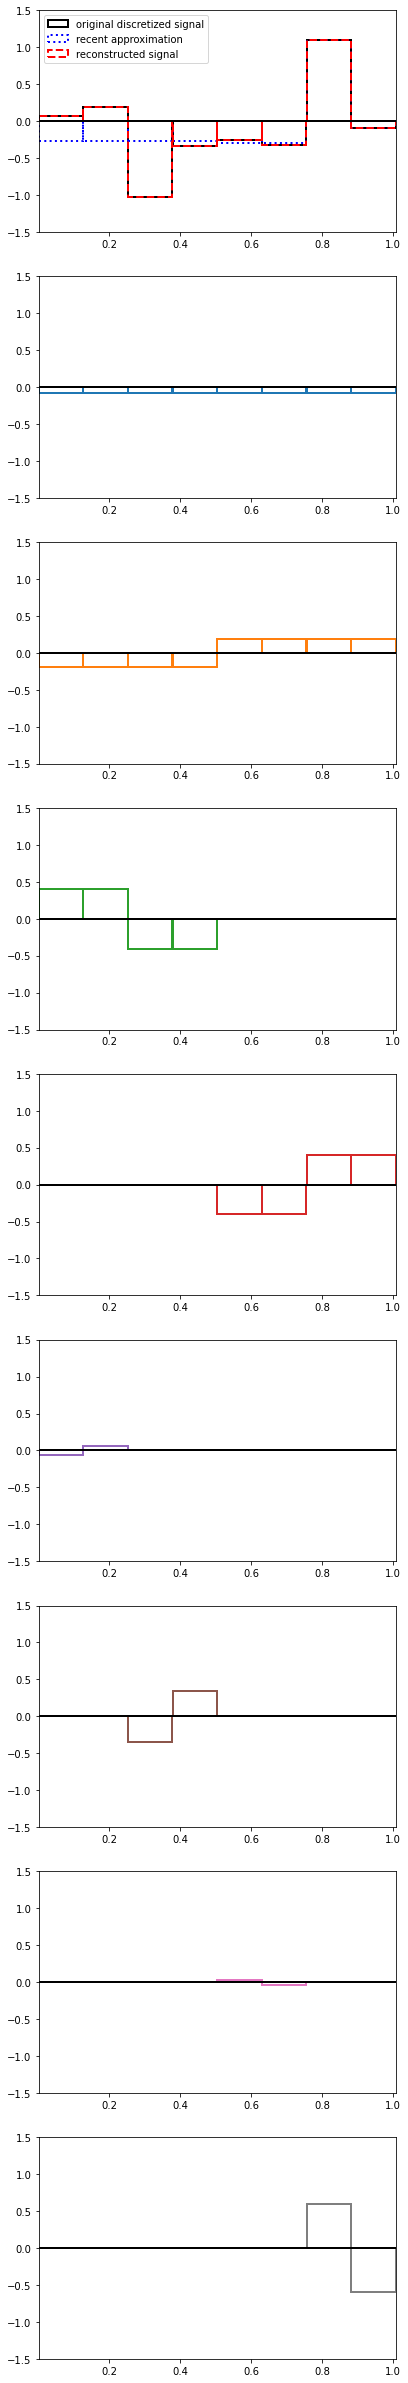

In [48]:
fig, axes = plt.subplots(nrows=len(y_comps) + 1, figsize=(6.4, 4.8 * (len(y_comps) + 1)))
ax = axes[0]
ax.bar(t, y, width=1/len(t), facecolor="None", edgecolor=f"k", bottom=0, linewidth=2., label="original discretized signal")

# approximation where we keep the most recent components of each level only:
ax.bar(t, y_comps[0] + y_comps[1] + y_comps[3] + y_comps[7], width=1/len(t), facecolor="None", edgecolor=f"blue", bottom=0, linewidth=2., ls="dotted", label="recent approximation")
#ax.bar(t, y_comps[0], width=1/len(t), facecolor="None", edgecolor=f"C0", bottom=0, linewidth=2., alpha=0.3)
#ax.bar(t, y_comps[1], width=1/len(t), facecolor="None", edgecolor=f"C1", bottom=0, linewidth=2., alpha=0.3)
#ax.bar(t, y_comps[3], width=1/len(t), facecolor="None", edgecolor=f"C3", bottom=0, linewidth=2., alpha=0.3)
#ax.bar(t, y_comps[7], width=1/len(t), facecolor="None", edgecolor=f"C7", bottom=0, linewidth=2., alpha=0.3)

ax.bar(t, np.stack(y_comps).sum(0), width=1/len(t), facecolor="None", edgecolor=f"r", bottom=0, linewidth=2., ls='--', label="reconstructed signal")
ax.legend()

ylim=[-1.5, 1.5]
ax.set(ylim=ylim)
ax.axhline(0, color="k", linewidth=2.)
ax.margins(x=0)
for i, y_comp in enumerate(y_comps):
  ax = axes.flatten()[i+1]
  ax.bar(t, y_comp, width=1/len(t), facecolor="None", edgecolor=f"C{i}", bottom=0, linewidth=2.)
  ax.set(ylim=ylim)
  ax.axhline(0, color="k", linewidth=2.)
  ax.margins(x=0)